**TODO:**
- [x] Plot the below on a custom categorical colormap to match the CIESIN visualization
- [x] Figure out projection stuff so we can display countries + coastlines on map (maybe use [earthpy](https://earthpy.readthedocs.io/en/latest/api/earthpy.plot.html)?)
- [x] Figure out how to programatically extract the relevant pixel value given a study lat/lon

# Setup

In [1]:
import json
import os

import rasterio
from rasterio.enums import Resampling

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np

# Loading population density raster

In [2]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']

# Grabbing 
year = 2000
pop_dens_paths = config['indiv_data_paths']['human_pop_density']
human_pop_dens2000 = os.path.join(pop_dens_paths['base_path'], pop_dens_paths['data_path'].format(year, year))

data_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, human_pop_dens2000)

In [3]:
# Resampling the array for visualization: https://rasterio.readthedocs.io/en/stable/topics/resampling.html
#  - probably better practice to download pre-prepared lower resolution versions from NASA, but this works for now!
upscale_factor = 1 / 20

with rasterio.open(data_path) as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape = (
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling = Resampling.average # seems the most reasonable resampling methods, since we're dealing with densities
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

data[data < 0] = np.nan # turning the fill value into NaN

# Plotting data

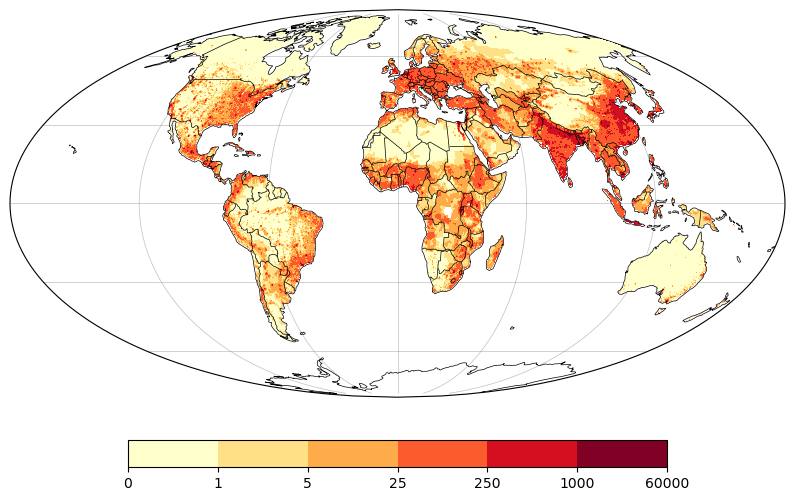

In [7]:
# Below code for color-mapping is from: https://stackoverflow.com/questions/61897393/unevenly-irregularly-spaced-data-for-colorbar-with-evenly-spaced-colors
uneven_levels = [0, 1, 5, 25, 250, 1000, 60000] # to match the SEDAC plot
cmap = plt.get_cmap('YlOrRd')
colors = cmap(np.linspace(0, 1, len(uneven_levels) - 1))
cmap, norm = mcolors.from_levels_and_colors(uneven_levels, colors)

# Setting things up for cartopy
xmin, ymin, xmax, ymax = list(dataset.bounds)

fig = plt.figure(figsize = (10, 14))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Mollweide())
ax.add_feature(cartopy.feature.BORDERS, linewidth = 0.5, zorder = 20)
ax.add_feature(cartopy.feature.COASTLINE, linewidth = 0.5, zorder = 20)

gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = False, linewidth = 0.5, color = 'gray', alpha = 0.5, zorder = 0)

# Plotting the data
im = ax.imshow(data.squeeze(), 
               cmap = cmap, norm = norm, 
               origin = 'upper', transform = ccrs.PlateCarree(), extent = [xmin, xmax, ymin, ymax],
               zorder = 10)

plt.colorbar(im, ax = ax, fraction = 0.025, pad = 0.04, orientation = 'horizontal')

# plt.savefig('/Users/emiliolr/Desktop/pop_density_map.png', bbox_inches = 'tight', dpi = 300)
plt.show();

# Extracting pixel values for a study location

Here, we don't need to re-project the coordinates since the data is already in WGS84 format. For others, we might need to project the desired lat/lon into coordinates for the data's CRS, then index.

In [9]:
# Grabbing a window around a desired lat/lon for a sanity check 
lat, lon = 38.8816, -77.0910 # Arlington, VA
N = 800

with rasterio.open(data_path) as dataset:
    py, px = dataset.index(lon, lat)
    window = rasterio.windows.Window(px - N // 2, py - N // 2, N, N)
    clip = dataset.read(1, window = window)

clip[clip < 0] = np.nan

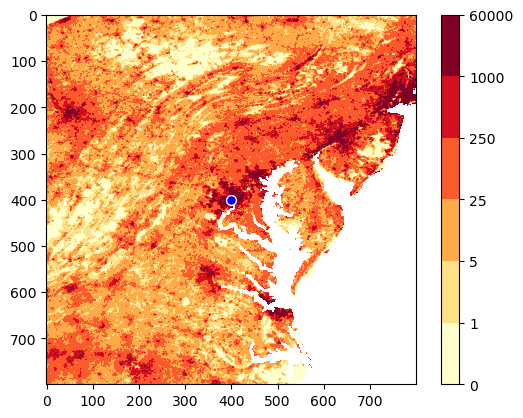

In [10]:
# This looks correct to me
plt.scatter([N // 2], [N // 2], s = 50, c = 'blue', edgecolor = 'white', zorder = 10)
plt.imshow(clip, cmap = cmap, norm = norm, zorder = 0)
plt.colorbar();

## Trying to extend the above to a script using Benitez-Lopez study locations

Basically, we'd like to grab the pixel value for all study locations and then store them in a tabular format... porbably using `pandas` along the way.